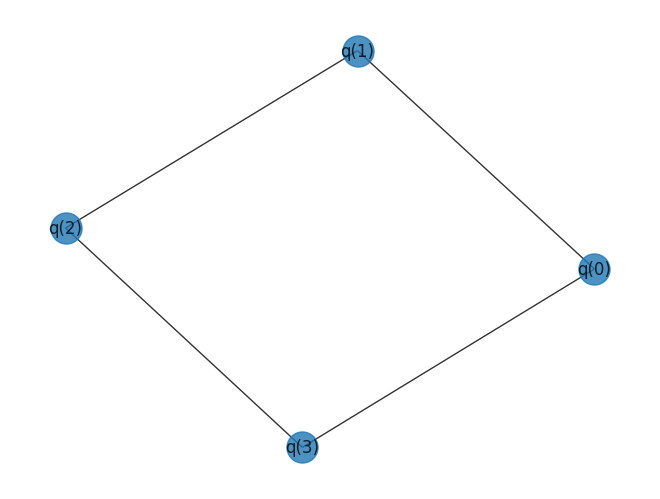

In [1]:
import networkx as nx
from networkx import Graph
from cirq import LineQubit

g = Graph()
nodes = [LineQubit(i) for i in range(4)]
edges = [(nodes[i], nodes[(i + 1) % 4]) for i in range(4)]
g.add_nodes_from(nodes)
g.add_edges_from(edges)
nx.draw(g, with_labels=True, alpha=0.8, node_size=500)

In [2]:
from cirq import Rx
from sympy import Symbol


def mixer(g: Graph, beta: Symbol):
    return [Rx(rads=2 * beta)(q) for q in list(g.nodes())]

In [3]:
from openfermion import Rzz


def problem(g: Graph, gamma: Symbol):
    return [Rzz(rads=2 * gamma)(i, j) for i, j in g.edges()]

In [4]:
from cirq import Circuit, H, measure, Moment


def create_qaoa_circ(g: Graph, theta: list[Symbol]):
    nodes = list(g.nodes())
    mid = len(theta) // 2
    betas = theta[:mid]
    gammas = theta[mid:]

    circuit = Circuit(H.on_each(*nodes))

    for i in range(mid):
        circuit.append(problem(g, gammas[i]))
        circuit.append(mixer(g, betas[i]))

    circuit.append(measure(*nodes, key="cut"))

    return circuit

In [5]:
from functools import reduce

def maxcut_obj(x: str, g: Graph):
    return reduce(lambda obj, e: obj - (1 if x[e[0].x] != x[e[1].x] else 0), g.edges(), 0)

In [6]:
from collections import Counter

def compute_expectation(cuts: Counter, g: Graph):
    sum, count = reduce(lambda t, c: (t[0] + (maxcut_obj(c, g) * cuts[c]), t[1] + cuts[c]), cuts, (0, 0))
    return sum / count

In [7]:
from cirq import Simulator


def get_expectation(g: Graph, nparams: int, shots=512):
    sim = Simulator()
    mid = nparams // 2
    betas = [Symbol(f"beta{i}") for i in range(mid)]
    gammas = [Symbol(f"gamma{i}") for i in range(mid)]
    theta = betas + gammas
    qc = create_qaoa_circ(g, theta)

    def execute_circ(params: list[float]):
        binding = {theta[i]:params[i] for i in range(len(params))}
        result = sim.run(qc, binding, shots)
        return compute_expectation(result.histogram(key="cut", fold_func=lambda x: ''.join(list(map(lambda i: str(i), x)))), g)

    return execute_circ

In [8]:
from scipy.optimize import minimize

init_params = [1.0, 1.0, 1.0, 1.0]
expectation = get_expectation(g, len(init_params))
res = minimize(expectation, init_params, method='COBYLA')
res

     fun: -3.9453125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 47
  status: 1
 success: True
       x: array([1.06243384, 1.02222543, 1.02881248, 1.06975707])

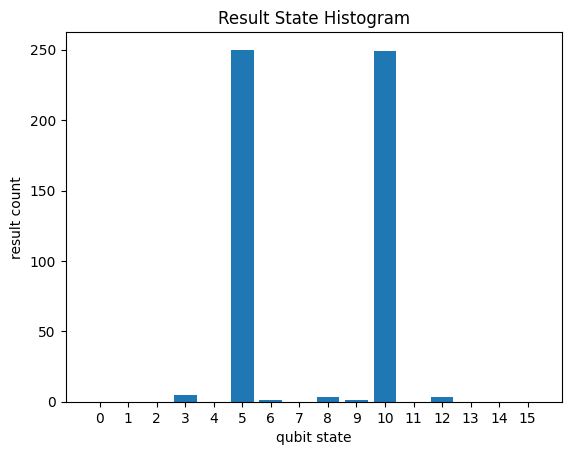

In [9]:
from cirq import plot_state_histogram
import matplotlib.pyplot as plt

betas = [Symbol("beta0"), Symbol("beta1")]
gammas = [Symbol("gamma0"), Symbol("gamma1")]
theta = betas + gammas
qc = create_qaoa_circ(g, theta)
binding = {theta[i]: res.x[i] for i in range(4)}
result = Simulator().run(qc, binding, 512)
plot_state_histogram(result, plt.subplot())

plt.show()